In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, random_split

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [25]:
x_train = df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
y_train = df.iloc[:, 0].values

In [26]:
scaler = MinMaxScaler()

x_train = x_train.reshape(-1, 28 * 28)
x_train = scaler.fit_transform(x_train).reshape(-1, 28, 28, 1).astype(np.float32)

test_x = test.values.reshape(-1, 28 * 28)
test_x = scaler.transform(test_x).reshape(-1, 28, 28, 1).astype(np.float32)

In [27]:
class CustomDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx] if self.labels is not None else -1
        if self.transform:
            image = self.transform(image)
        return image, label

In [53]:
transform_1 = transforms.Compose([
    transforms.ToTensor(),
])

transform_2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

In [54]:
dataset_no_transform = CustomDataset(x_train, y_train, transform=transform_1)
dataset_with_transform = CustomDataset(x_train, y_train, transform=transform_2)
dataset = dataset_no_transform + dataset_with_transform
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [64]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 3 * 3, 300)
        self.fc2 = nn.Linear(300, 10)
        self.adjust_channels1 = nn.Conv2d(16, 32, kernel_size=1)
        self.adjust_channels2 = nn.Conv2d(32, 64, kernel_size=1)

    def forward(self, x):
        initalizer = x
        out = F.relu(self.dropout1(self.conv1_1(x)))
        out = F.relu(self.dropout1(self.conv1_2(out)))
        out = out + initalizer
        out = self.pool(out)
        initalizer = self.adjust_channels1(out)
        out = F.relu(self.dropout1(self.conv2_1(out)))
        out = F.relu(self.dropout1(self.conv2_2(out)))
        out = out + initalizer
        out = self.pool(out)
        initalizer = self.adjust_channels2(out)
        out = F.relu(self.dropout1(self.conv3_1(out)))
        out = F.relu(self.dropout1(self.conv3_2(out)))
        out = out + initalizer
        out = self.pool(out)
        out = out.view(-1, 64 * 3 * 3)
        out = F.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)
        return out

In [65]:
model = CNNModel().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

CNNModel(
  (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=576, out_features=300, bias=True)
  (fc2): Linear

In [66]:
epochs = 100
patience = 3
best_val_loss = float('inf')
counter = 0

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0.0
    total = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    model.eval()
    val_loss = 0.0
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    scheduler.step()
    
    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}%, Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Epoch 1/100, Train Loss: 0.2448, Val Loss: 0.0901, Train Acc: 0.9219%, Val Acc: 0.9699
Epoch 2/100, Train Loss: 0.0838, Val Loss: 0.0573, Train Acc: 0.9745%, Val Acc: 0.9816
Epoch 3/100, Train Loss: 0.0630, Val Loss: 0.0424, Train Acc: 0.9806%, Val Acc: 0.9864
Epoch 4/100, Train Loss: 0.0511, Val Loss: 0.0437, Train Acc: 0.9841%, Val Acc: 0.9864
Epoch 5/100, Train Loss: 0.0424, Val Loss: 0.0299, Train Acc: 0.9868%, Val Acc: 0.9901
Epoch 6/100, Train Loss: 0.0344, Val Loss: 0.0319, Train Acc: 0.9888%, Val Acc: 0.9896
Epoch 7/100, Train Loss: 0.0330, Val Loss: 0.0266, Train Acc: 0.9899%, Val Acc: 0.9910
Epoch 8/100, Train Loss: 0.0285, Val Loss: 0.0301, Train Acc: 0.9915%, Val Acc: 0.9898
Epoch 9/100, Train Loss: 0.0251, Val Loss: 0.0224, Train Acc: 0.9921%, Val Acc: 0.9926
Epoch 10/100, Train Loss: 0.0237, Val Loss: 0.0235, Train Acc: 0.9927%, Val Acc: 0.9923
Epoch 11/100, Train Loss: 0.0217, Val Loss: 0.0227, Train Acc: 0.9932%, Val Acc: 0.9929
Epoch 12/100, Train Loss: 0.0200, Val Los

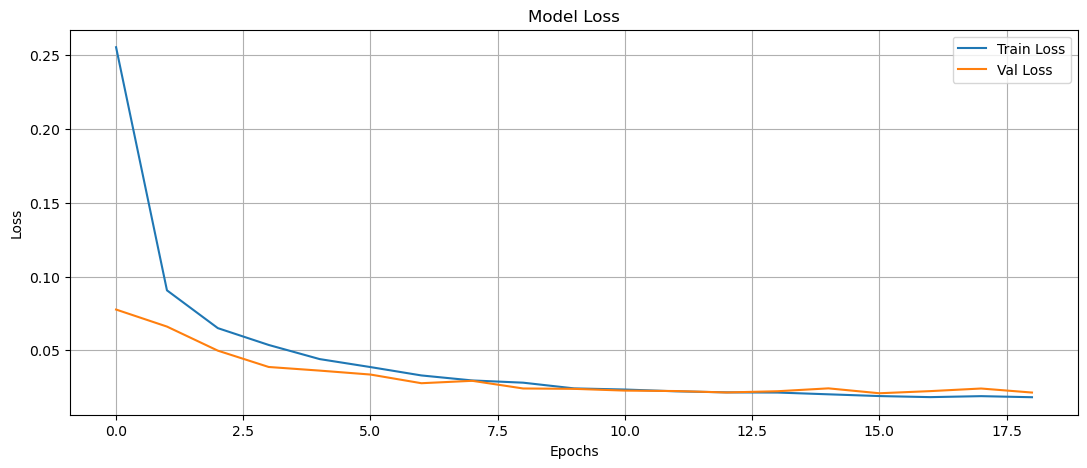

In [58]:
plt.figure(figsize=(13, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

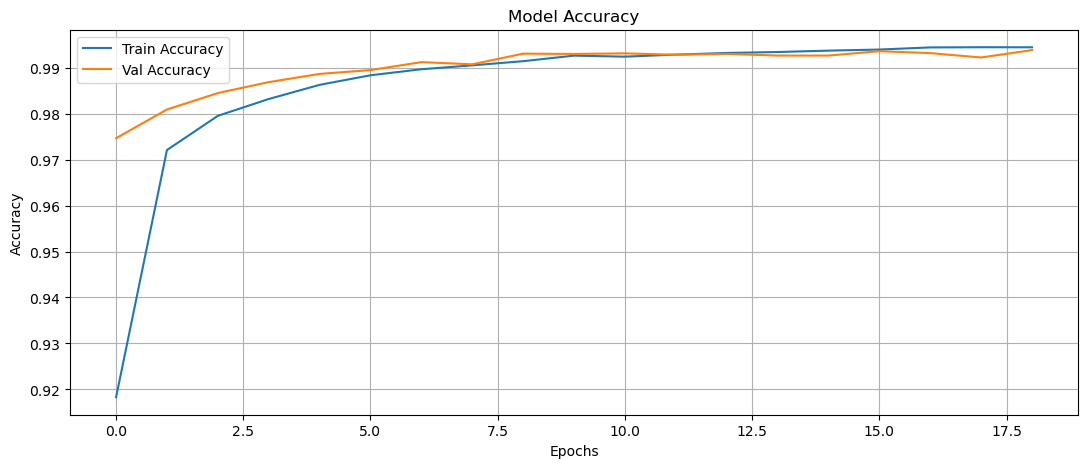

In [59]:
plt.figure(figsize=(13, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [60]:
test_dataset = CustomDataset(test_x, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [61]:
# model.load_state_dict(torch.load('best_model.pth'))
# model.eval()

In [62]:
pred_labels = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        pred_labels.extend(predicted.cpu().numpy())

In [63]:
sub['Label'] = pred_labels
sub.to_csv("data/sample_submission.csv", index=False)
print(sub.head())

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3


In [52]:
image = (np.array(
    Image.open('C:\\Users\\pasag\\Desktop\\digit photo\\7.jpg').convert('L').resize((28, 28))) / 255.0).astype(
    np.float32)
image = torch.tensor(image).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    model.eval()
    output = model(image)
    print(torch.argmax(output, dim=1).item())

8
